#  End to End Customer Churn and Sales Analysis


## Project Overview

**Project Name:** End to End Customer Churn, Employee Analysis, and Sales Analysis

**Objective:** 
The primary goal of this project is to build an end-to-end data pipeline for analyzing customer churn, employee performance, and sales data. The project integrates data from Snowflake, processes it using PySpark, and loads the results into PostgreSQL for further analysis and reporting.

### Key Components

1. **Data Extraction:**
   - **Source:** Snowflake
   - **Purpose:** Extract relevant datasets from Snowflake that include customer information, employee performance metrics, sales data, and supply chain details.

2. **Data Processing:**
   - **Tool:** PySpark
   - **Purpose:** Process and transform the extracted data to generate insights on customer churn, employee performance, and sales metrics. This includes:
     - **Customer Churn Analysis:** Identify patterns and factors contributing to customer churn.
     - **Employee Performance Analysis:** Assess employee performance based on sales data.
     - **Sales Analysis:** Analyze sales trends, including total sales and average discounts by product and region.
     - **Supply Chain Analysis:** Evaluate supply chain performance by analyzing supplier and product data.

3. **Data Loading:**
   - **Destination:** PostgreSQL
   - **Purpose:** Store the processed data into PostgreSQL tables for easy access and further analysis. The tables include:
     - `customer_churn`: Insights into customer churn patterns.
     - `employee_performance`: Metrics on employee sales performance.
     - `sales_analysis`: Analysis of sales data by product and region.
     - `supply_chain_analysis`: Details on supply chain performance.

4. **Data Pipeline Automation:**
   - **Tool:** Prefect
   - **Purpose:** Automate the end-to-end data pipeline, ensuring that data extraction, processing, and loading are performed on a scheduled basis with monitoring and error handling.

## Reasoning

1. **Business Needs:**
   - **Customer Churn:** Understanding customer churn helps businesses identify at-risk customers and develop retention strategies, leading to improved customer satisfaction and revenue.
   - **Employee Performance:** Analyzing employee performance helps organizations recognize high performers, identify training needs, and optimize sales strategies.
   - **Sales Analysis:** Insights into sales trends and patterns support better inventory management, pricing strategies, and market targeting.
   - **Supply Chain Analysis:** Evaluating supply chain performance helps in optimizing procurement, managing supplier relationships, and reducing costs.

2. **Technical Approach:**
   - **Snowflake:** Chosen as the source due to its scalability and ease of integration with Spark.
   - **PySpark:** Provides a powerful framework for distributed data processing, suitable for handling large datasets and complex transformations.
   - **PostgreSQL:** Used as the destination database due to its robust features and compatibility with analytical tools.
   - **Prefect:** Selected for its ease of use in workflow orchestration, providing features for scheduling, monitoring, and error handling.

3. **Integration:**
   - The integration of Snowflake, PySpark, PostgreSQL, and Prefect ensures a seamless end-to-end pipeline, allowing for efficient data extraction, processing, and analysis.

4. **Scalability and Maintainability:**
   - The architecture is designed to be scalable, handling increasing data volumes and complexity. The use of Prefect for workflow management ensures that the pipeline is maintainable and adaptable to future changes or enhancements.


# Tools that will be used

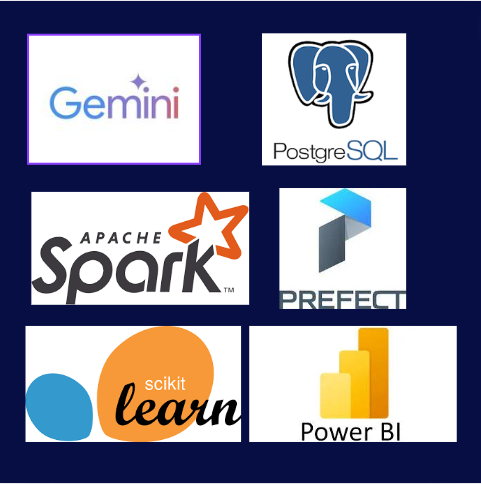

# Project Workflow

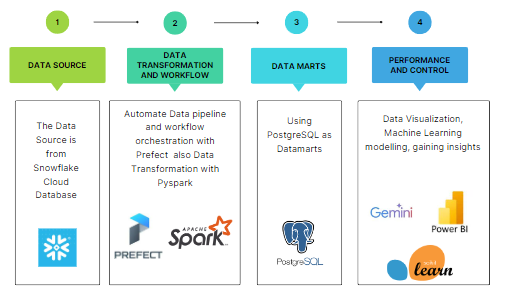

# ERD Diagram

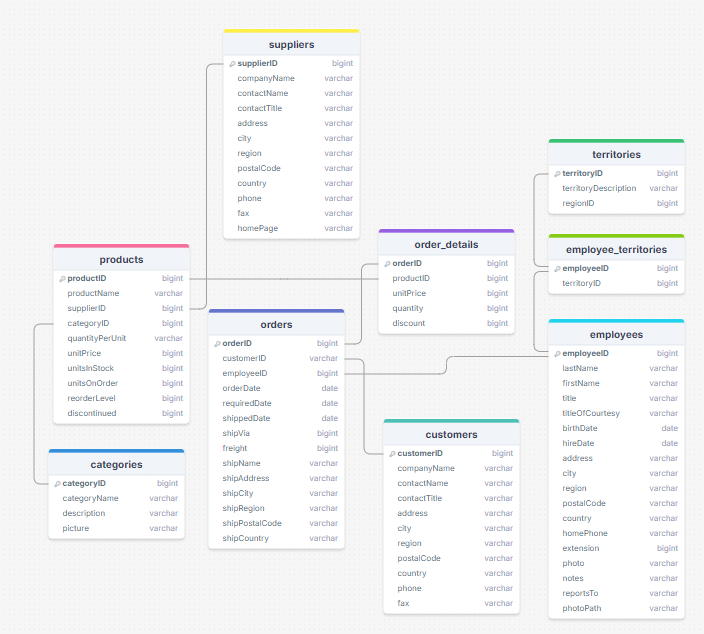

# Data Pipeline and Processing with Pyspark and Prefect

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
from prefect import task, flow
import psycopg2

# Initialize SparkSession with Snowflake and PostgreSQL JDBC drivers
spark = SparkSession.builder \
    .appName("SnowflakeToPostgreSQL") \
    .config("spark.jars", "C:\\Users\\Michael\\Pyspark\\snowflake-jdbc-3.13.30.jar,C:\\Users\\Michael\\Pyspark\\spark-snowflake_2.12-2.13.0-spark_3.4.jar,C:\\Users\\Michael\\Pyspark\\postgresql-42.7.3.jar") \
    .getOrCreate()

# Snowflake connection options
sfOptions = {
    "sfURL": "https://ar37313.europe-west4.gcp.snowflakecomputing.com",
    "sfAccount": "ar37313.europe-west4.gcp",
    "sfUser": "MAGICDASH",
    "sfPassword": "********************",
    "sfDatabase": "SUPERMARKET_DATA",
    "sfSchema": "PUBLIC",
    "sfWarehouse": "COMPUTE_WH",
    "sfRole": "ACCOUNTADMIN"
}

SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"

# PostgreSQL connection options
jdbc_url = "jdbc:postgresql://localhost:5432/project3"
connection_properties = {
    "user": "postgres",
    "password": "*********************",
    "driver": "org.postgresql.Driver"
}

# PostgreSQL connection for schema checking and altering
def get_postgresql_connection():
    return psycopg2.connect(
        dbname="project3",
        user="postgres",
        password="********************",
        host="localhost",
        port="5432"
    )

@task
def check_table_exists(table_name: str) -> bool:
    try:
        conn = get_postgresql_connection()
        cursor = conn.cursor()
        cursor.execute(f"SELECT EXISTS (SELECT 1 FROM information_schema.tables WHERE table_name = '{table_name}');")
        exists = cursor.fetchone()[0]
        cursor.close()
        conn.close()
        return exists
    except Exception as e:
        print("Error checking table existence:", e)
        return False

@task
def execute_query(query: str, table_name: str):
    try:
        # Read data from Snowflake using SQL query
        df = spark.read \
            .format(SNOWFLAKE_SOURCE_NAME) \
            .options(**sfOptions) \
            .option("query", query) \
            .load()

        # Check if table exists in PostgreSQL
        if check_table_exists(table_name):
            print(f"Table '{table_name}' exists. Replacing the table.")
            # Optionally: Modify schema if needed
            # (e.g., using ALTER TABLE statements, but typically, it's simpler to overwrite)
            df.write \
                .format("jdbc") \
                .option("url", jdbc_url) \
                .option("dbtable", table_name) \
                .option("user", connection_properties["user"]) \
                .option("password", connection_properties["password"]) \
                .option("driver", connection_properties["driver"]) \
                .mode("overwrite") \
                .save()
        else:
            print(f"Table '{table_name}' does not exist. Creating and writing to the table.")
            df.write \
                .format("jdbc") \
                .option("url", jdbc_url) \
                .option("dbtable", table_name) \
                .option("user", connection_properties["user"]) \
                .option("password", connection_properties["password"]) \
                .option("driver", connection_properties["driver"]) \
                .mode("overwrite") \
                .save()

        print(f"Data written to PostgreSQL table '{table_name}' successfully!")

    except AnalysisException as e:
        print("AnalysisException:", e)
    except Exception as e:
        print("Exception:", e)

@flow
def data_pipeline():
    # Define SQL queries
    customer_churn = """
    SELECT
        p.productName,
        p.quantityPerUnit,
        p.unitPrice AS product_unitPrice,
        p.discontinued,
        c.categoryName,
        o.shipCountry,
        od.unitPrice AS order_unitPrice,
        od.quantity,
        od.discount,
        cu.contactName,
        cu.contactTitle,
        cu.country AS customer_country
    FROM
        products p
    INNER JOIN
        categories c ON p.categoryID = c.categoryID
    INNER JOIN
        order_details od ON p.productID = od.productID
    INNER JOIN
        orders o ON od.orderID = o.orderID
    INNER JOIN
        customers cu ON o.customerID = cu.customerID
    """

    employee_performance_query = """
    SELECT
        e.employeeID,
        e.lastName,
        e.firstName,
        SUM(od.unitPrice * od.quantity * (1 - od.discount)) AS total_sales
    FROM
        employees e
    INNER JOIN
        orders o ON e.employeeID = o.employeeID
    INNER JOIN
        order_details od ON o.orderID = od.orderID
    GROUP BY
        e.employeeID, e.lastName, e.firstName
    """

    sales_analysis_query = """
    SELECT
        p.productName,
        c.categoryName,
        o.shipCountry,
        SUM(od.unitPrice * od.quantity * (1 - od.discount)) AS total_sales,
        AVG(od.discount) AS avg_discount
    FROM
        products p
    INNER JOIN
        categories c ON p.categoryID = c.categoryID
    INNER JOIN
        order_details od ON p.productID = od.productID
    INNER JOIN
        orders o ON od.orderID = o.orderID
    GROUP BY
        p.productName, c.categoryName, o.shipCountry
    """

    supply_chain_analysis_query = """
    SELECT
        s.companyName AS supplierName,
        p.productName,
        SUM(od.quantity) AS total_units
    FROM
        suppliers s
    INNER JOIN
        products p ON s.supplierID = p.supplierID
    INNER JOIN
        order_details od ON p.productID = od.productID
    GROUP BY
        s.companyName, p.productName
    """

    # Call tasks within the flow
    execute_query(customer_churn, "customer_churn")
    execute_query(employee_performance_query, "employee_performance")
    execute_query(sales_analysis_query, "sales_analysis")
    execute_query(supply_chain_analysis_query, "supply_chain_analysis")

# Run the flow
if __name__ == "__main__":
    data_pipeline()

# Stop the Spark session
spark.stop()


# Prefect Workflow Orchestration

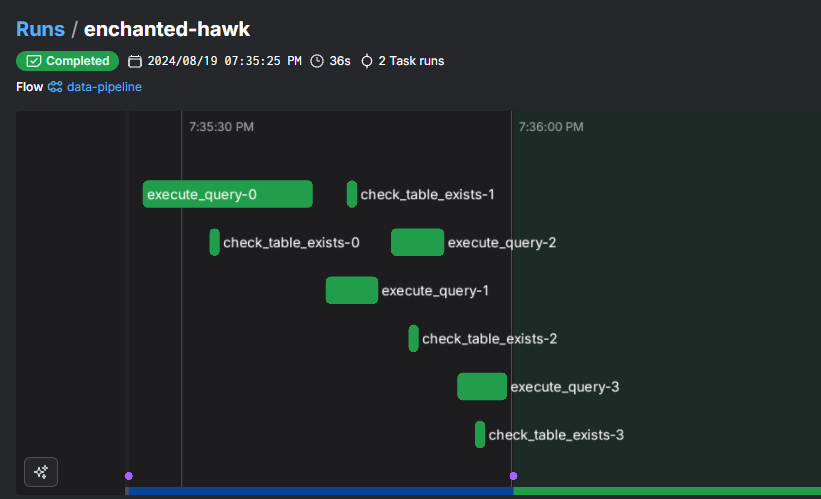

# Import all of the Data from PostgreSQL Datamart

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(color_codes=True)

In [7]:
import pandas as pd
import psycopg2
from psycopg2 import OperationalError

try:
    # Attempt to establish a connection to PostgreSQL
    connection = psycopg2.connect(
        host="localhost",
        dbname="project3",
        user="postgres",
        password="***********************",
        port="5432"
    )
    print("Connection Success")
    
except OperationalError as e:
    print("Connection Failed")
    print(f"Error details: {e}")

Connection Success


In [8]:
query = "SELECT * FROM public.customer_churn"
df = pd.read_sql_query(query, connection)
df.head()

C:\Users\Michael\AppData\Local\Temp\ipykernel_23772\3554500076.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,PRODUCTNAME,QUANTITYPERUNIT,PRODUCT_UNITPRICE,DISCONTINUED,CATEGORYNAME,SHIPCOUNTRY,ORDER_UNITPRICE,QUANTITY,DISCOUNT,CONTACTNAME,CONTACTTITLE,CUSTOMER_COUNTRY
0,Queso Cabrales,1 kg pkg.,21.00,0.0,Dairy Products,France,14.0,12.0,0.0,Paul Henriot,Accounting Manager,France
1,Singaporean Hokkien Fried Mee,32 - 1 kg pkgs.,14.00,1.0,Grains/Cereals,France,9.8,10.0,0.0,Paul Henriot,Accounting Manager,France
2,Mozzarella di Giovanni,24 - 200 g pkgs.,34.80,0.0,Dairy Products,France,34.8,5.0,0.0,Paul Henriot,Accounting Manager,France
3,Tofu,40 - 100 g pkgs.,23.25,0.0,Produce,Germany,18.6,9.0,0.0,Karin Josephs,Marketing Manager,Germany
4,Manjimup Dried Apples,50 - 300 g pkgs.,53.00,0.0,Produce,Germany,42.4,40.0,0.0,Karin Josephs,Marketing Manager,Germany


# Data Preprocessing

In [10]:
# List the columns you want to drop
columns_to_drop = ['PRODUCTNAME', 'QUANTITYPERUNIT', 'CONTACTNAME']

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# Display the resulting DataFrame
df.head()

,PRODUCT_UNITPRICE,DISCONTINUED,CATEGORYNAME,SHIPCOUNTRY,ORDER_UNITPRICE,QUANTITY,DISCOUNT,CONTACTTITLE,CUSTOMER_COUNTRY
0,21.00,0.0,Dairy Products,France,14.0,12.0,0.0,Accounting Manager,France
1,14.00,1.0,Grains/Cereals,France,9.8,10.0,0.0,Accounting Manager,France
2,34.80,0.0,Dairy Products,France,34.8,5.0,0.0,Accounting Manager,France
3,23.25,0.0,Produce,Germany,18.6,9.0,0.0,Marketing Manager,Germany
4,53.00,0.0,Produce,Germany,42.4,40.0,0.0,Marketing Manager,Germany


# Check the amount of unique value for each object datatype column

In [11]:
# Select only columns with object (string) data type
object_columns = df.select_dtypes(include='object')

# Calculate the number of unique values for each object-type column
unique_values = object_columns.nunique()

# Display the result
print(unique_values)

CATEGORYNAME         8
SHIPCOUNTRY         21
CONTACTTITLE        12
CUSTOMER_COUNTRY    21
dtype: int64


In [13]:
# Check the amount of unique values in 'discontinued' and 'discount' columns
unique_discontinued = df['DISCONTINUED'].nunique()
unique_discount = df['DISCOUNT'].nunique()

# Display the results
print(f"Unique values in 'discontinued': {unique_discontinued}")
print(f"Unique values in 'discount': {unique_discount}")

Unique values in 'discontinued': 2
Unique values in 'discount': 1


In [14]:
# Drop discount column because only have 1 unique value
df.drop(columns='DISCOUNT', inplace=True)
df.head()

,PRODUCT_UNITPRICE,DISCONTINUED,CATEGORYNAME,SHIPCOUNTRY,ORDER_UNITPRICE,QUANTITY,CONTACTTITLE,CUSTOMER_COUNTRY
0,21.00,0.0,Dairy Products,France,14.0,12.0,Accounting Manager,France
1,14.00,1.0,Grains/Cereals,France,9.8,10.0,Accounting Manager,France
2,34.80,0.0,Dairy Products,France,34.8,5.0,Accounting Manager,France
3,23.25,0.0,Produce,Germany,18.6,9.0,Marketing Manager,Germany
4,53.00,0.0,Produce,Germany,42.4,40.0,Marketing Manager,Germany


# Check the amount of missing value on each column

In [15]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean() * 100

# Display the result
print(missing_percentage)

PRODUCT_UNITPRICE    0.0
DISCONTINUED         0.0
CATEGORYNAME         0.0
SHIPCOUNTRY          0.0
ORDER_UNITPRICE      0.0
QUANTITY             0.0
CONTACTTITLE         0.0
CUSTOMER_COUNTRY     0.0
dtype: float64


# Label Encoding for each Object datatype

In [16]:
# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:

    # Print the column name and the unique values
    print(f"{col}: {df[col].unique()}")

CATEGORYNAME: ['Dairy Products' 'Grains/Cereals' 'Produce' 'Seafood' 'Condiments'
 'Confections' 'Beverages' 'Meat/Poultry']
SHIPCOUNTRY: ['France' 'Germany' 'Brazil' 'Belgium' 'Switzerland' 'Venezuela' 'Austria'
 'Mexico' 'USA' 'Sweden' 'Finland' 'Italy' 'Spain' 'UK' 'Ireland'
 'Portugal' 'Canada' 'Denmark' 'Poland' 'Norway' 'Argentina']
CONTACTTITLE: ['Accounting Manager' 'Marketing Manager' 'Sales Agent' 'Owner'
 'Sales Manager' 'Sales Representative' 'Assistant Sales Representative'
 'Marketing Assistant' 'Order Administrator' 'Assistant Sales Agent'
 'Sales Associate' 'Owner/Marketing Assistant']
CUSTOMER_COUNTRY: ['France' 'Germany' 'Brazil' 'Belgium' 'Switzerland' 'Venezuela' 'Austria'
 'Mexico' 'USA' 'Sweden' 'Finland' 'Italy' 'Spain' 'UK' 'Ireland'
 'Portugal' 'Canada' 'Denmark' 'Poland' 'Norway' 'Argentina']


In [17]:
from sklearn import preprocessing

# Loop over each column in the DataFrame where dtype is 'object'
for col in df.select_dtypes(include=['object']).columns:

    # Initialize a LabelEncoder object
    label_encoder = preprocessing.LabelEncoder()

    # Fit the encoder to the unique values in the column
    label_encoder.fit(df[col].unique())

    # Transform the column using the encoder
    df[col] = label_encoder.transform(df[col])

    # Print the column name and the unique encoded values
    print(f"{col}: {df[col].unique()}")

CATEGORYNAME: [3 4 6 7 1 2 0 5]
SHIPCOUNTRY: [ 7  8  3  2 17 20  1 11 19 16  6 10 15 18  9 14  4  5 13 12  0]
CONTACTTITLE: [ 0  4  8  6 10 11  2  3  5  1  9  7]
CUSTOMER_COUNTRY: [ 7  8  3  2 17 20  1 11 19 16  6 10 15 18  9 14  4  5 13 12  0]


# Correlation Heatmap

<Axes: >

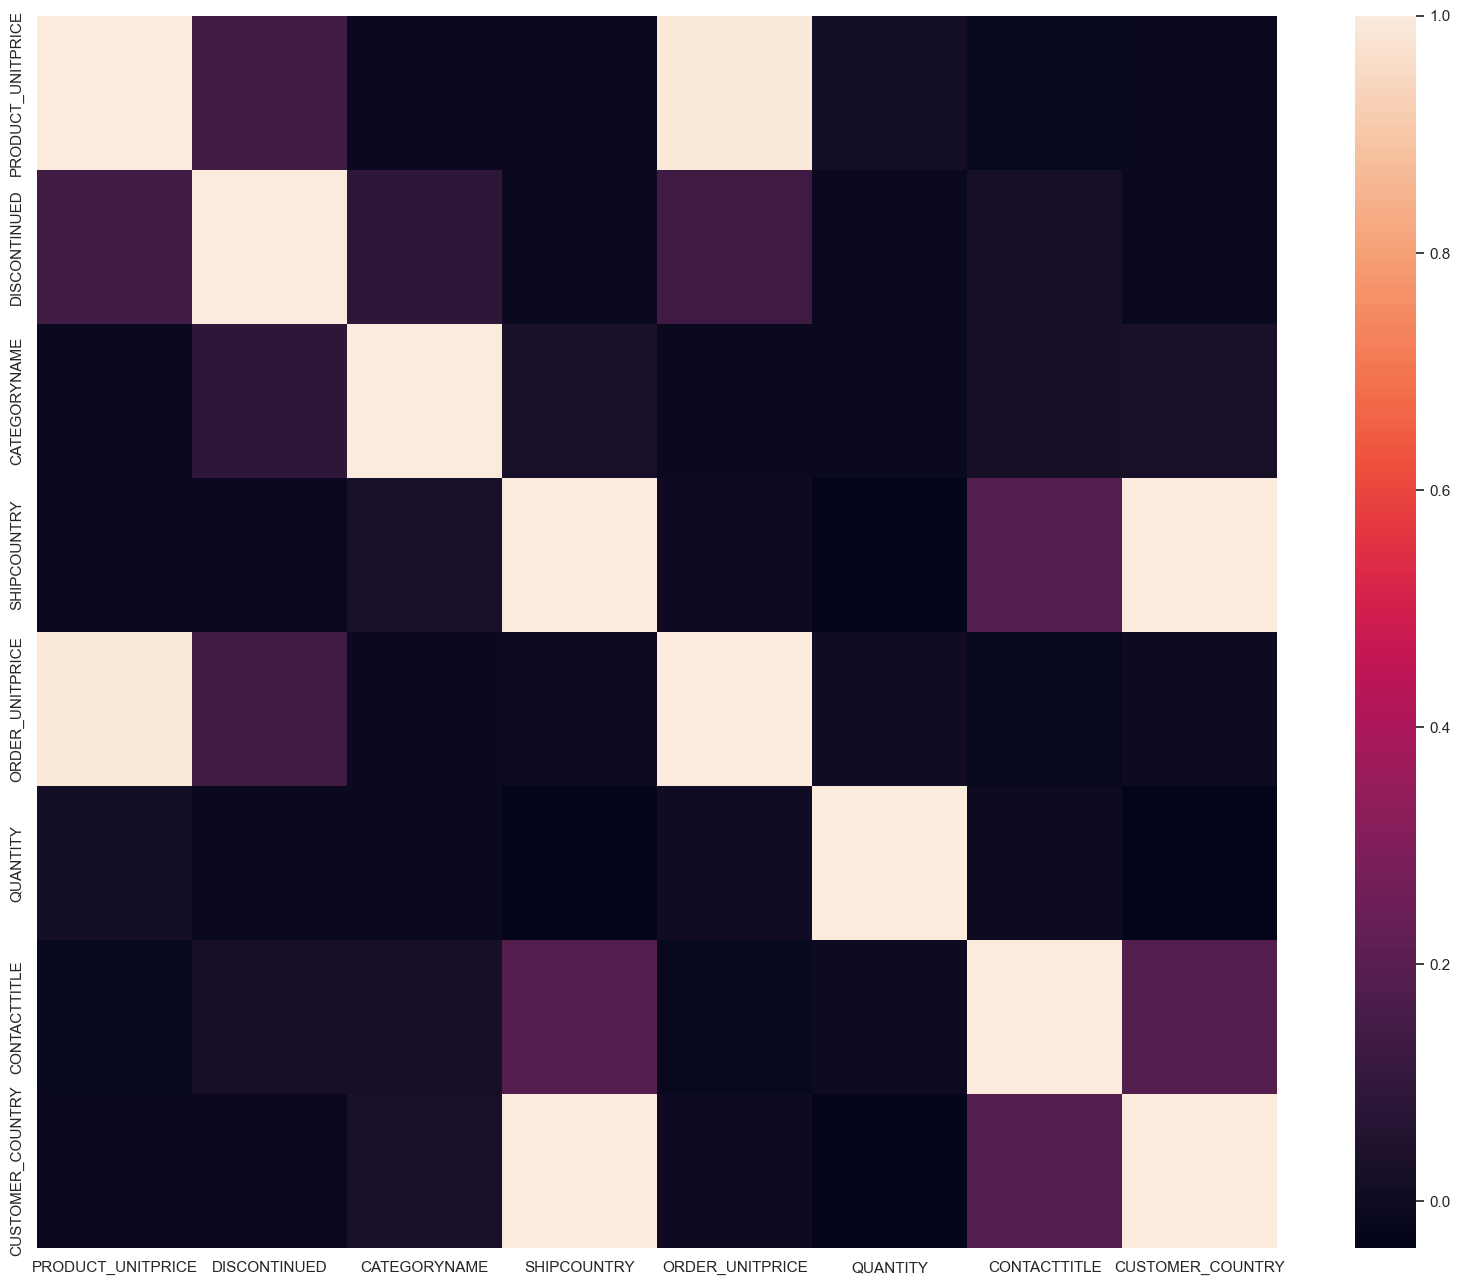

In [20]:
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), fmt='.2g')

# Drop product unit price column because it have same correlation with order unit price


In [21]:
df.drop(columns='PRODUCT_UNITPRICE', inplace=True)
df.head()

,DISCONTINUED,CATEGORYNAME,SHIPCOUNTRY,ORDER_UNITPRICE,QUANTITY,CONTACTTITLE,CUSTOMER_COUNTRY
0,0.0,3,7,14.0,12.0,0,7
1,1.0,4,7,9.8,10.0,0,7
2,0.0,3,7,34.8,5.0,0,7
3,0.0,6,8,18.6,9.0,4,8
4,0.0,6,8,42.4,40.0,4,8


# Machine Learning Modelling

In [22]:
from sklearn.model_selection import train_test_split
# Select the features (X) and the target variable (y)
X = df.drop('DISCONTINUED', axis=1)
y = df['DISCONTINUED']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc = RandomForestClassifier(class_weight='balanced')
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [0, 42]
}

# Perform a grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)

{'max_depth': 10, 'max_features': None, 'n_estimators': 100, 'random_state': 42}


In [24]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, max_depth=3, max_features=None, n_estimators=200, class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None,
                       n_estimators=200, random_state=42)

In [25]:
from sklearn.metrics import accuracy_score
y_pred = rfc.predict(X_test)
print("Accuracy Score :", round(accuracy_score(y_test, y_pred)*100 ,2), "%")

Accuracy Score : 87.7 %


In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score, log_loss
print('F-1 Score : ',(f1_score(y_test, y_pred, average='micro')))
print('Precision Score : ',(precision_score(y_test, y_pred, average='micro')))
print('Recall Score : ',(recall_score(y_test, y_pred, average='micro')))
print('Jaccard Score : ',(jaccard_score(y_test, y_pred, average='micro')))
print('Log Loss : ',(log_loss(y_test, y_pred)))

F-1 Score :  0.877030162412993
Precision Score :  0.877030162412993
Recall Score :  0.877030162412993
Jaccard Score :  0.78099173553719
Log Loss :  4.432282203302109


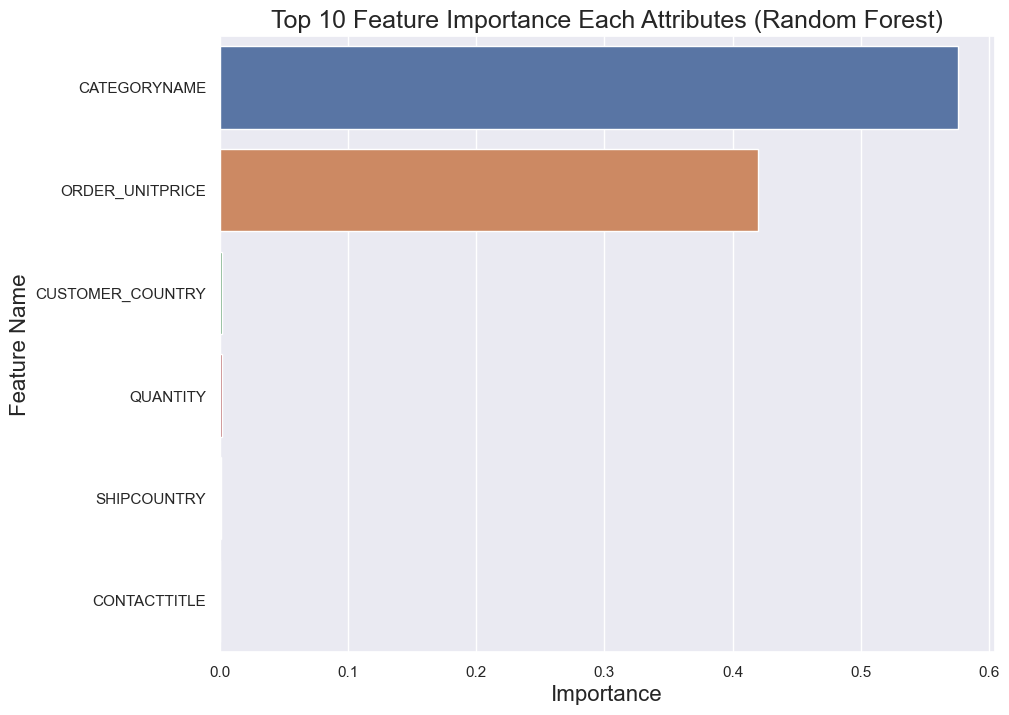

In [27]:
imp_df = pd.DataFrame({
    "Feature Name": X_train.columns,
    "Importance": rfc.feature_importances_
})
fi = imp_df.sort_values(by="Importance", ascending=False)

fi2 = fi.head(10)
plt.figure(figsize=(10,8))
sns.barplot(data=fi2, x='Importance', y='Feature Name')
plt.title('Top 10 Feature Importance Each Attributes (Random Forest)', fontsize=18)
plt.xlabel ('Importance', fontsize=16)
plt.ylabel ('Feature Name', fontsize=16)

# Save the plot as a PNG file
plt.savefig('feature_importance.png', format='png', bbox_inches='tight')

plt.show()

# Google Gemini Analysis

In [30]:
import textwrap
import google.generativeai as genai
from IPython.display import display
from IPython.display import Markdown

In [31]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="******************************")

import PIL.Image

img = PIL.Image.open("feature_importance.png")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content(["Explain it by points in simple and clear terms. Provide key findings and actionable insights based on the random forest classifier feature importance", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The Random Forest classifier feature importance plot shows the top 10 features that are most important for predicting the target variable.  Here is a breakdown:
> 
> * **CATEGORYNAME** is the most important feature. This means that the product category has a significant impact on the target variable.
> * **ORDER_UNITPRICE** is the second most important feature. This indicates that the price of the product is a crucial factor in predicting the target variable.
> * **CUSTOMER_COUNTRY** is the third most important feature. This suggests that the customer's location plays a role in predicting the target variable.
> * **QUANTITY** is the fourth most important feature. This implies that the number of products ordered is also a significant factor.
> 
> Based on these findings, here are some actionable insights:
> 
> * **Focus on CATEGORYNAME:**  The product category is the most crucial factor in predicting the target variable. It is important to carefully consider the category of products when making decisions.
> * **Optimize ORDER_UNITPRICE:**  The price of the product is also very important. By optimizing prices, you can improve the accuracy of your predictions.
> * **Consider CUSTOMER_COUNTRY:**  The customer's location is a significant factor. It is important to take this into account when making predictions.
> * **Use QUANTITY as a predictor:**  The number of products ordered can also be used to predict the target variable.
> * **Further investigation:**  The features that are not shown in the plot may also be important. It is worth investigating these features further to see if they can improve the accuracy of your predictions.


# K-Means Clustering Analysis

In [32]:
df.head()

,DISCONTINUED,CATEGORYNAME,SHIPCOUNTRY,ORDER_UNITPRICE,QUANTITY,CONTACTTITLE,CUSTOMER_COUNTRY
0,0.0,3,7,14.0,12.0,0,7
1,1.0,4,7,9.8,10.0,0,7
2,0.0,3,7,34.8,5.0,0,7
3,0.0,6,8,18.6,9.0,4,8
4,0.0,6,8,42.4,40.0,4,8


# Pick the Attribute for Clustering

In [34]:
X=df[["ORDER_UNITPRICE","QUANTITY"]]
X.head()

,ORDER_UNITPRICE,QUANTITY
0,14.0,12.0
1,9.8,10.0
2,34.8,5.0
3,18.6,9.0
4,42.4,40.0


In [35]:
# Make 3 Clusters
from sklearn.cluster import KMeans
km1=KMeans(n_clusters=3, random_state=0)
km1.fit(X)
y=km1.predict(X)
df["cluster"] = y
df.head()

C:\Users\Michael\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Michael\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


,DISCONTINUED,CATEGORYNAME,SHIPCOUNTRY,ORDER_UNITPRICE,QUANTITY,CONTACTTITLE,CUSTOMER_COUNTRY,cluster
0,0.0,3,7,14.0,12.0,0,7,2
1,1.0,4,7,9.8,10.0,0,7,2
2,0.0,3,7,34.8,5.0,0,7,2
3,0.0,6,8,18.6,9.0,4,8,2
4,0.0,6,8,42.4,40.0,4,8,0


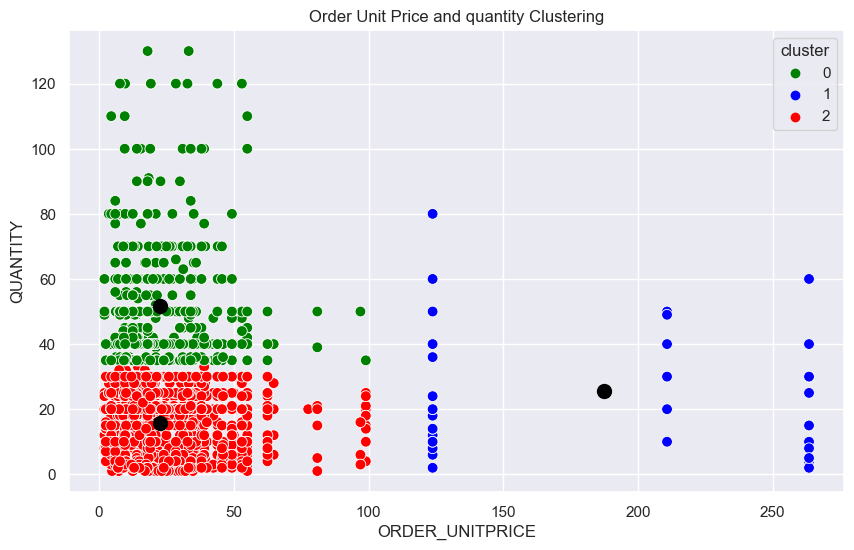

In [36]:
#Scatterplot of the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'ORDER_UNITPRICE',y = 'QUANTITY',hue="cluster",
                 palette=['green','blue','red'], legend='full',data = df,s = 60 )
plt.scatter(km1.cluster_centers_[:, 0], km1.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
plt.xlabel('ORDER_UNITPRICE')
plt.ylabel('QUANTITY')
plt.title('Order Unit Price and quantity Clustering')

# Save the plot as a PNG file
plt.savefig('cluster.png', format='png', bbox_inches='tight')
plt.show()

In [37]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="*******************************")

import PIL.Image

img = PIL.Image.open("cluster.png")
model = genai.GenerativeModel('gemini-1.5-flash')
response = model.generate_content(img)

response = model.generate_content(["Explain it by points in simple and clear terms. Provide key findings and actionable insights based on the cluster data", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The graph shows the clustering of order unit price and quantity. The clusters are color-coded as follows:
> 
> - **Cluster 0:** Green dots represent orders with a low unit price and a moderate quantity.
> - **Cluster 1:** Blue dots represent orders with a high unit price and a low quantity.
> - **Cluster 2:** Red dots represent orders with a low unit price and a low quantity.
> 
> **Key Findings:**
> 
> - The data shows three distinct clusters of orders based on unit price and quantity.
> - Cluster 0 represents a large number of orders with a lower unit price and a relatively higher quantity. This cluster could represent standard orders for frequently purchased items.
> - Cluster 1 represents a smaller number of orders with a high unit price and a low quantity. This cluster could represent orders for high-value items or bulk purchases.
> - Cluster 2 represents orders with low unit price and low quantity. This cluster could represent orders for promotional items or smaller items.
> 
> **Actionable Insights:**
> 
> - **Focus on maximizing sales from Cluster 0:** This cluster has the highest potential for sales volume. Strategies could include promotions, bundles, and loyalty programs to encourage repeat purchases.
> - **Optimize pricing for Cluster 1:** The high unit price in this cluster suggests a premium market.  Focus on providing high-quality products and services to justify the higher cost.
> - **Analyze Cluster 2:**  Investigate why customers are placing these orders. It could be a result of low-value products, promotional offers, or sampling.  Make sure this cluster isn't losing revenue. 
> - **Tailor marketing campaigns for each cluster:** Using segmentation allows for targeted promotions and communications, increasing the effectiveness of marketing efforts.
> 
> Overall, understanding these clusters can help businesses optimize their pricing, inventory, and marketing strategies to increase sales and profitability.


# Power BI Dashboard Analysis

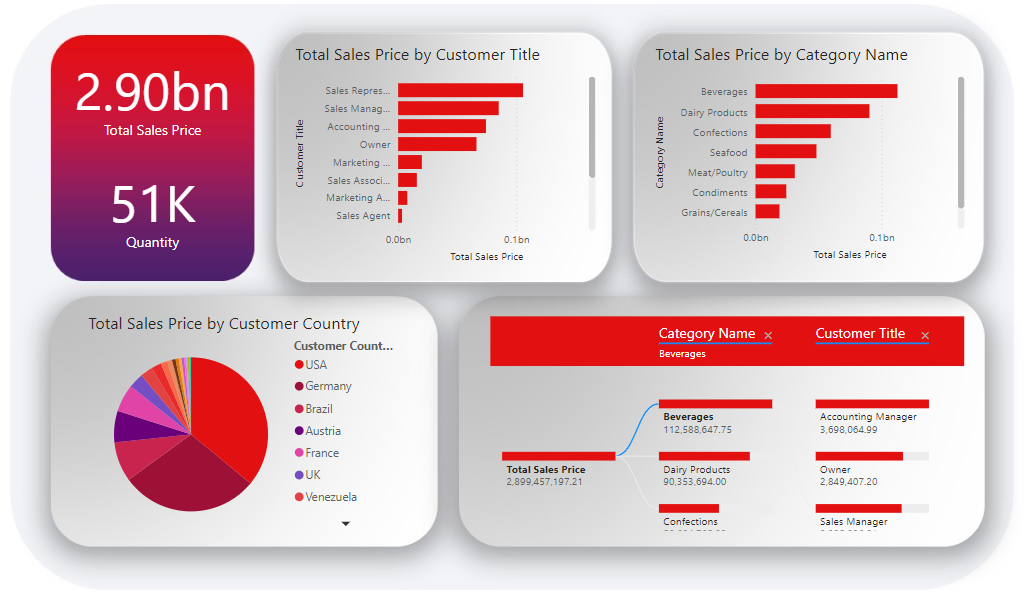

In [38]:
from IPython.display import Image, display

# Display the image
display(Image(filename='dashboard.PNG'))

In [40]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="******************************")

import PIL.Image

img = PIL.Image.open("dashboard.PNG")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content(["Explain it by points in simple and clear terms. Provide key findings and actionable insights based on the content", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> ## Key Findings and Actionable Insights:
> 
> **Overall Performance:**
> 
> * **Total Sales Price:** 2.90 billion 
> * **Quantity Sold:** 51,000
> * **Top Performing Category:** Beverages with 112.588 billion in sales
> * **Top Performing Country:** USA
> * **Top Performing Customer Title:** Accounting Manager with 3.698 billion in sales 
> 
> **Actionable Insights:**
> 
> * **Focus on Beverages:**  Beverages are the top performing category, contributing significantly to the total sales. Invest in marketing and promotions for this category to further increase sales.
> * **Target USA:** USA is the top performing country by a large margin. Consider expanding outreach and marketing efforts in the USA.
> * **Empower Sales Representatives:** Sales Representatives and Sales Managers are top performing customer titles. Provide them with the tools and resources they need to continue driving sales.
> * **Boost Sales from Owner Customers:** Owners contribute significantly to sales. Offer them exclusive deals or loyalty programs to further incentivize purchases.
> * **Diversify Customer Base:** While the USA is a strong market, consider expanding to other countries to diversify the customer base and reduce dependence on a single market.
> * **Analyze Performance by Category and Country:**  Deep dive into the performance of each category and country to identify areas for improvement and opportunities for growth.
> 
> **Important Notes:**
> 
> * The data is based on the visual representation of the image provided. Further analysis with actual data is needed for more accurate insights.
> * The image lacks details on individual product sales. This information is crucial to identify specific products driving revenue and those requiring attention. 


# Employee Performance Analysis

In [41]:
query = "SELECT * FROM public.employee_performance"
df = pd.read_sql_query(query, connection)
df.head()

C:\Users\Michael\AppData\Local\Temp\ipykernel_23772\1589966735.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,EMPLOYEEID,LASTNAME,FIRSTNAME,TOTAL_SALES
0,5.0,Buchanan,Steven,75567.75
1,6.0,Suyama,Michael,78198.10
2,4.0,Peacock,Margaret,250187.45
3,3.0,Leverling,Janet,213051.30
4,9.0,Dodsworth,Anne,82964.00


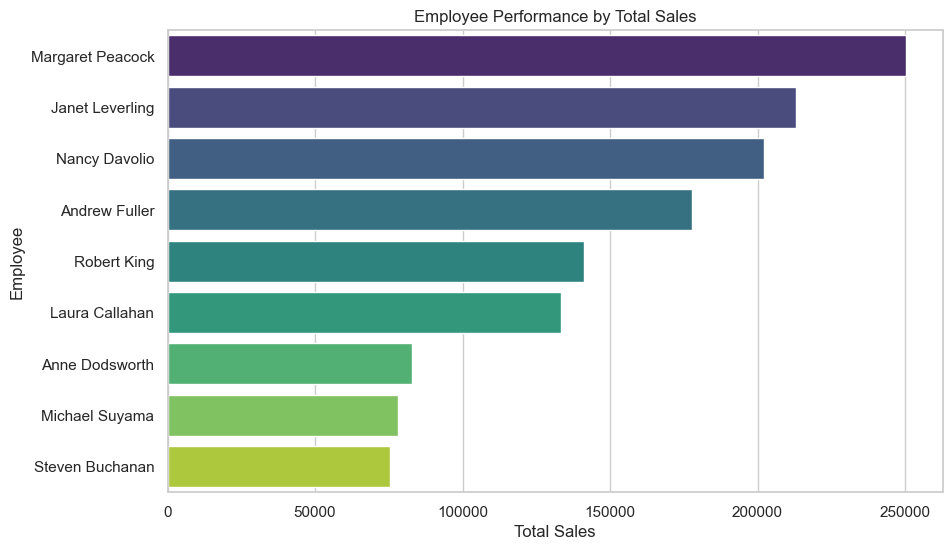

In [43]:
# Combine FIRSTNAME and LASTNAME into a single column
df['FULLNAME'] = df['FIRSTNAME'] + ' ' + df['LASTNAME']

# Sort the DataFrame by TOTAL_SALES in descending order
df_sorted = df.sort_values(by='TOTAL_SALES', ascending=False)

# Set the Seaborn style
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='TOTAL_SALES', y='FULLNAME', data=df_sorted, palette='viridis')

# Add labels and title
plt.xlabel('Total Sales')
plt.ylabel('Employee')
plt.title('Employee Performance by Total Sales')

# Save the plot as a PNG file
plt.savefig('employee.png')

# Show the plot (optional)
plt.show()

In [45]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="*************************************")

import PIL.Image

img = PIL.Image.open("employee.PNG")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content(["Analyze the following employee performance data and provide a summary in simple and clear terms.  "
                                   "1. Identify key trends and patterns in the total sales data. "
                                   "2. Highlight any notable performance differences between employees. "
                                   "3. Provide actionable insights based on the sales performance. "
                                   "Provide a clear explanation and use the image to illustrate your points where relevant.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The bar chart displays the total sales performance of 8 employees.  The data shows a significant difference in performance between employees, with Margaret Peacock being the top performer and Steven Buchanan being the lowest performer. 
> 
> **Key Trends:**
> 
> * There is a noticeable difference in the total sales generated by employees.
> * Margaret Peacock has the highest sales, followed by Janet Leverling, Nancy Davolio, and Andrew Fuller.
> * The bottom half of performers are clustered closer together, indicating a more even performance level in this group.
> 
> **Performance Differences:**
> 
> * Margaret Peacock significantly outperforms all other employees with the highest total sales.
> * Janet Leverling and Nancy Davolio show considerable sales performance, but still fall short of Margaret Peacock's level.
> * The middle performers (Robert King, Laura Callahan, and Anne Dodsworth)  have similar sales performance.
> * Steven Buchanan and Michael Suyama have the lowest sales performance.
> 
> **Actionable Insights:**
> 
> * **Identify the factors contributing to Margaret Peacock's high performance.** This could include her sales strategies, customer relationships, or product knowledge. 
> * **Provide targeted training and support to employees in the lower performance group.** This could include coaching on sales techniques, product knowledge, or customer engagement.
> * **Consider implementing a mentorship program.** Pair high-performing employees like Margaret Peacock with lower-performing employees to share knowledge and best practices.
> * **Analyze individual sales data for each employee.** This will help identify specific areas for improvement and provide more tailored support.
> * **Recognize and reward high performance.** Publicly acknowledge and celebrate Margaret Peacock's success to motivate the entire team. 
> 
> By analyzing employee performance data and taking action based on the insights, the company can help improve overall sales performance and create a more motivated and productive sales team. 


# Sales Analysis

In [46]:
query = "SELECT * FROM public.sales_analysis"
df = pd.read_sql_query(query, connection)
df.head()

C:\Users\Michael\AppData\Local\Temp\ipykernel_23772\1862514067.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,PRODUCTNAME,CATEGORYNAME,SHIPCOUNTRY,TOTAL_SALES,AVG_DISCOUNT
0,Queso Cabrales,Dairy Products,France,1113.0,0.0
1,Singaporean Hokkien Fried Mee,Grains/Cereals,France,725.2,0.0
2,Mozzarella di Giovanni,Dairy Products,France,2593.4,0.0
3,Tofu,Produce,Germany,1869.3,0.0
4,Manjimup Dried Apples,Produce,Germany,7791.0,0.0


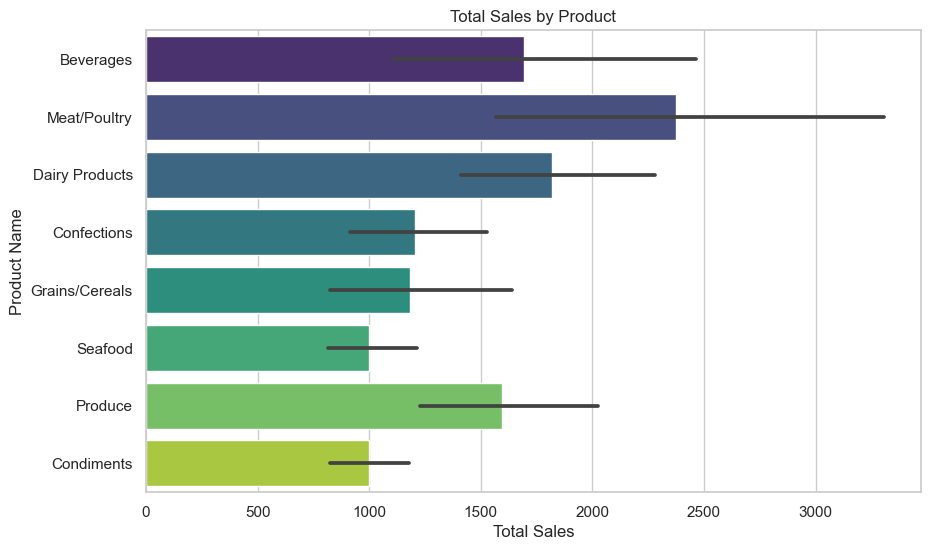

In [54]:
# Sort the DataFrame by TOTAL_SALES in descending order
df_sorted = df.sort_values(by='TOTAL_SALES', ascending=False)

# Set the Seaborn style
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="TOTAL_SALES", y="CATEGORYNAME", data=df_sorted, palette="viridis")

# Add labels and title
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.title('Total Sales by Product')

# Save the plot as a PNG file
plt.savefig('sales_analysis.png')

# Show the plot (optional)
plt.show()

In [51]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="**********************************")

import PIL.Image

img = PIL.Image.open("sales_analysis.PNG")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content(["Analyze the following sales data and provide a summary in simple and clear terms."
                                   "1. Identify key trends and patterns in the total sales by product and category. "
                                   "2. Highlight notable differences in sales across different categories. "
                                   "3. Provide actionable insights based on the total sales. "
                                   "Use the image to illustrate your points where relevant.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The chart shows the total sales by product category. Here's a summary:
> 
> **Key Trends and Patterns:**
> 
> * **Meat/Poultry** has the highest total sales, followed by **Beverages**. 
> * **Condiments** has the lowest total sales.
> * The sales are generally spread out across different categories.
> 
> **Notable Differences:**
> 
> * There is a significant difference in sales between the top two categories (Meat/Poultry and Beverages) and the rest.
> * **Dairy Products** and **Confections** have similar sales, while **Grains/Cereals** and **Seafood** also have comparable sales.
> 
> **Actionable Insights:**
> 
> * **Focus on high-selling categories:** The company should continue to focus on selling Meat/Poultry and Beverages as they are driving the most revenue.
> * **Explore growth opportunities in other categories:**  While the top two categories are strong performers, there's potential to increase sales in other categories such as Produce, Dairy Products, or Confections. 
> * **Consider promotions or marketing campaigns:** Implementing targeted promotions or marketing campaigns for specific categories like Condiments could help boost sales. 
> * **Analyze product performance within categories:** Further analysis of individual products within each category could reveal which products are driving the most sales and which need improvement. 
> 
> By focusing on these key insights, the company can make informed decisions to optimize sales and drive further growth. 


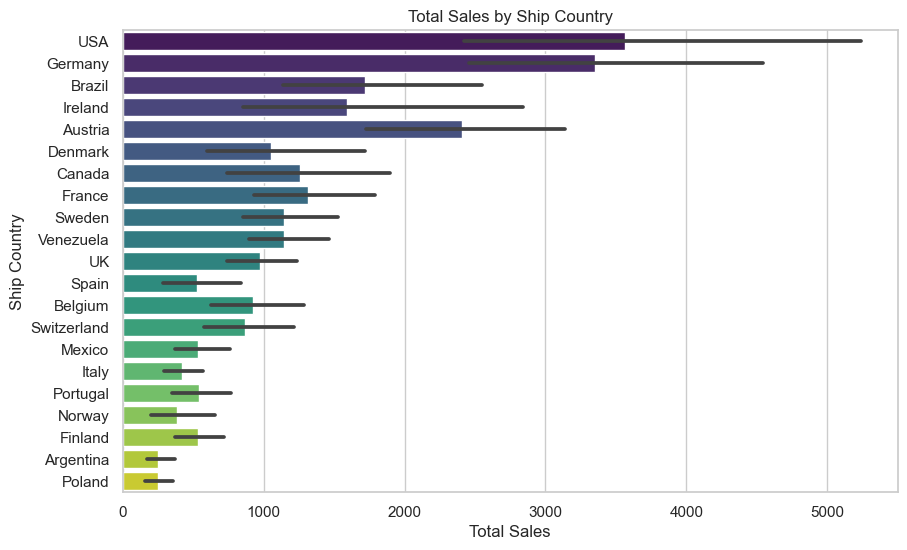

In [53]:
# Sort the DataFrame by TOTAL_SALES in descending order
df_sorted = df.sort_values(by='TOTAL_SALES', ascending=False)

# Set the Seaborn style
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="TOTAL_SALES", y="SHIPCOUNTRY", data=df_sorted, palette="viridis")

# Add labels and title
plt.xlabel('Total Sales')
plt.ylabel('Ship Country')
plt.title('Total Sales by Ship Country')

# Save the plot as a PNG file
plt.savefig('sales_country.png')

# Show the plot (optional)
plt.show()

In [55]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="*****************************************")

import PIL.Image

img = PIL.Image.open("sales_country.PNG")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content(["Analyze the following sales data and provide a summary in simple and clear terms." 
                                   "1. Identify key trends and patterns in the total sales by ship countries." 
                                   "2. Highlight notable differences in sales across different countries."
                                   "3. Provide actionable insights based on the total sales."
                                   "Use the image to illustrate your points where relevant.", img], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The bar chart shows the total sales by ship country. Here's a breakdown of the data:
> 
> **Key trends and patterns:**
> 
> * **USA and Germany are the top performing countries.** They have significantly higher total sales compared to other countries.
> * **Sales are generally higher in Western European countries.**  Countries like Ireland, Austria, Denmark, France, and Sweden also demonstrate considerable sales figures.
> * **Sales decrease significantly as we move down the list.** Countries like Argentina, Poland, and Finland have much lower sales compared to the top performers.
> 
> **Notable differences in sales across different countries:**
> 
> * **USA and Germany:**  They have the highest sales, with the USA significantly outperforming Germany.
> * **Western Europe vs. Other Regions:**  Western European countries generally have higher sales than countries in other regions (South America, Eastern Europe, Asia).
> * **Low Sales Countries:**  Countries like Argentina, Poland, and Finland have very low sales volumes compared to the top performers.
> 
> **Actionable insights:**
> 
> * **Focus on expanding sales in the USA and Germany:** These markets are already strong, but there is potential for further growth.
> * **Explore opportunities in Western Europe:** This region demonstrates consistent sales performance.
> * **Develop strategies to increase sales in underperforming countries:** Analyze reasons for lower sales in countries like Argentina, Poland, and Finland, and implement targeted strategies to boost their performance.
> * **Consider focusing on specific regions or countries with high potential:** This may involve tailoring marketing efforts and product offerings to specific markets to maximize impact.
> 
> **Overall, the data suggests that the company is doing well in the USA, Germany, and Western Europe. However, there is room for improvement in other regions. By focusing on these areas, the company can further increase its sales and achieve its business goals.**


# Supply Chain Analysis

In [56]:
query = "SELECT * FROM public.supply_chain_analysis"
df = pd.read_sql_query(query, connection)
df.head()

C:\Users\Michael\AppData\Local\Temp\ipykernel_23772\3177914821.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,SUPPLIERNAME,PRODUCTNAME,TOTAL_UNITS
0,Cooperativa de Quesos 'Las Cabras',Queso Cabrales,706.0
1,Leka Trading,Singaporean Hokkien Fried Mee,697.0
2,Formaggi Fortini s.r.l.,Mozzarella di Giovanni,806.0
3,Mayumi's,Tofu,404.0
4,G'day Mate,Manjimup Dried Apples,886.0


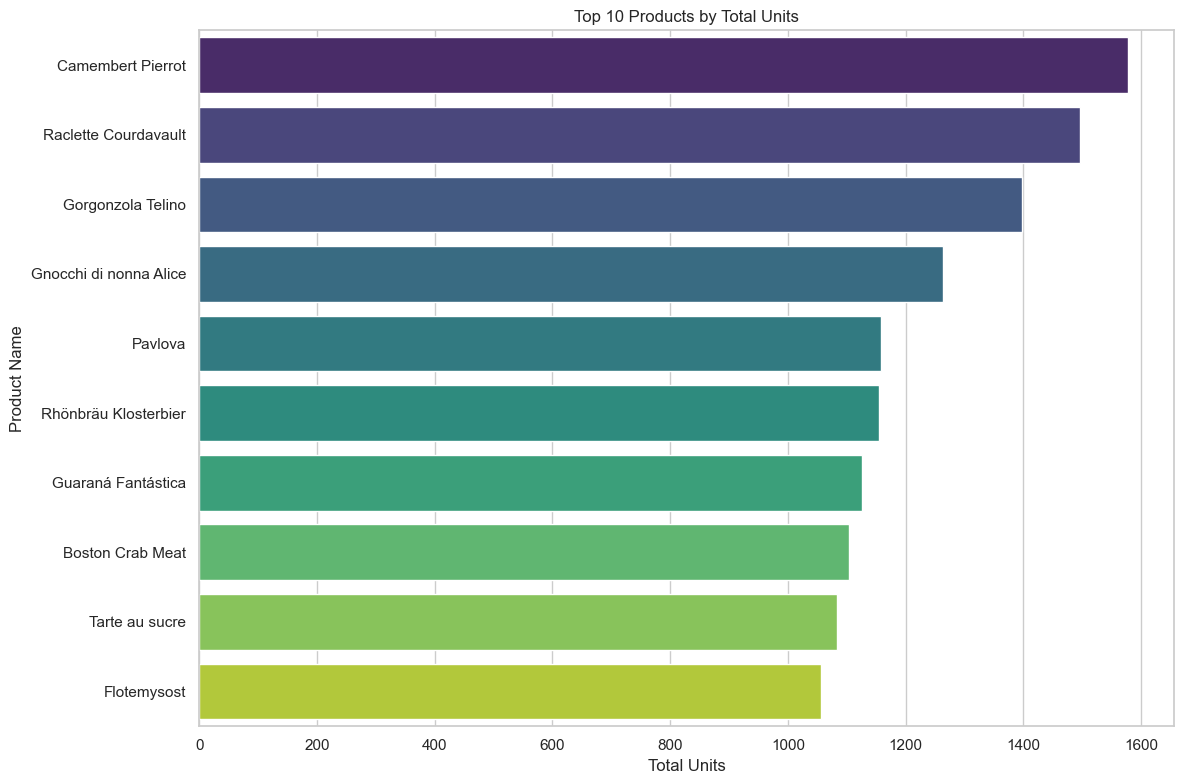

In [57]:
# Sort by TOTAL_UNITS in descending order and select top 10
top_10_df = df.sort_values(by='TOTAL_UNITS', ascending=False).head(10)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a barplot
sns.barplot(x="TOTAL_UNITS", y="PRODUCTNAME", data=top_10_df, palette="viridis")

# Set labels and title
plt.xlabel("Total Units")
plt.ylabel("Product Name")
plt.title("Top 10 Products by Total Units")

# Show the plot
plt.tight_layout()
plt.savefig("supply_chain_analysis.png")  # Save the plot as an image file
plt.show()

In [58]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

genai.configure(api_key="***************************************")

import PIL.Image

img = PIL.Image.open("supply_chain_analysis.PNG")
model = genai.GenerativeModel('gemini-1.5-flash-latest')
response = model.generate_content(img)

response = model.generate_content([
    "Analyze the following supply chain data and provide a summary in simple and clear terms. "
    "1. Identify key trends and patterns in the total units for the top products. "
    "2. Highlight any notable differences in the total units across different products. "
    "3. Provide actionable insights based on the total units of the top products. "
    "Use the image to illustrate your points where relevant.", img
], stream=True)
response.resolve()
formatted_text = to_markdown(response.text)
display(formatted_text)

> The bar chart shows the top 10 products by total units sold.  
> 
> **Key Trends and Patterns**
> 
> - There is a clear trend of decreasing total units as you move down the list of top products.
> - The top 3 products (Camembert Pierrot, Raclette Courdavault, Gorgonzola Telino) have significantly higher total units than the rest of the products.
> 
> **Notable Differences**
> 
> - Camembert Pierrot has the highest total units, followed by Raclette Courdavault.
> - The products ranked 4th to 10th have total units clustered between 1000 and 1200.
> 
> **Actionable Insights**
> 
> - **Focus on top-performing products:**  The top 3 products are clear winners in terms of demand.  Focus on strategies to maintain and increase sales of these products.
> - **Investigate the performance of the lower-ranked products:** Why are the units lower for these products? Are there pricing, marketing, or availability issues?
> - **Consider product assortment:** The data suggests that there might be a smaller market for the lower-ranked products. It may be beneficial to analyze customer preferences and optimize the product assortment.
> - **Invest in demand forecasting:** Accurate demand forecasting for top-performing products will help optimize inventory management and reduce stockouts.
> 
> In summary, the data highlights the need to focus on the top-performing products while simultaneously evaluating the performance of the lower-ranked products and potentially adjusting the product assortment to better meet customer demand. 
